<a href="https://colab.research.google.com/github/abhinav-exp/ELM_Implementaion/blob/main/HHO_ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [45]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [46]:
denormalize = lambda x: (x)*np.float64(data1max - data1min + 2) + np.float64(data1min - 1)

In [47]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x)
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [48]:
train_x = data3.iloc[:int(0.85*len(data3)), :-1]
train_y = data3.iloc[:int(0.85*len(data3)), -1:]
test_x = data3.iloc[int(0.85*len(data3)):, :-1]
test_y = data3.iloc[int(0.85*len(data3)):, -1:]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(655, 9)
(655, 1)
(116, 9)
(116, 1)


In [80]:
class HHO_ELM():
  def __init__(self, p_size):
    self.p_size = p_size
    self.no_hidden_nodes = 5
    self.weight = np.random.uniform(-1, 1, (self.p_size, 9, self.no_hidden_nodes))
    self.bias = np.random.uniform(-1, 1, (self.p_size, self.no_hidden_nodes))
    self.beta = np.random.uniform(-1, 1, (self.p_size, self.no_hidden_nodes, 1))
    self.train_px = np.tile(np.expand_dims(train_x, axis = 0), (p_size, 1, 1))
    self.train_py = np.tile(np.expand_dims(train_y, axis = 0), (p_size, 1, 1))
    self.fitness = np.zeros([self.p_size, 1]) + -1 * np.Inf
    self.forward_propagation(self.beta)
    self.best_error_graph = np.array([-1 * np.max(self.fitness)])

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-1 * x))

  def forward_function(self, weight, bias, beta, X):
    a = np.matmul(X, weight)
    c = np.expand_dims(bias, axis = len(bias.shape) - 1)
    b = a + c
    return self.sigmoid(np.matmul(b, beta))

  def forward_propagation(self, new_beta):
    preds = self.forward_function(self.weight, self.bias, new_beta, self.train_px)
    error = (preds - self.train_py) ** 2
    new_fitness = -np.mean(error, axis = 1)
    cond = new_fitness > self.fitness
    self.beta = np.where(np.expand_dims(cond, axis = 1), new_beta, self.beta)
    self.fitness = np.where(cond, new_fitness, self.fitness)

    sorted_indices = np.argsort(self.fitness[:, 0])
    self.weight = self.weight[sorted_indices]
    self.bias = self.bias[sorted_indices]
    self.beta = self.beta[sorted_indices]
    self.fitness = self.fitness[sorted_indices]

  def optimise(self, gen):
    for i in range(gen):
      half_size = int(np.floor(self.p_size / 2))

      r1 = np.random.uniform(size = (self.p_size, self.no_hidden_nodes, 1))
      r2 = np.random.uniform(size = (self.p_size, self.no_hidden_nodes, 1))
      A1 = 2 * r1 - 1
      C1 = 2 * r2

      C2 = self.beta.copy()
      C2[half_size:] = self.beta[0].copy()

      A2 = self.beta.copy()
      A2[:half_size] = self.beta[half_size].copy()

      new_beta = self.beta + np.abs(C1 * C2 - A1 * A2)
      new_beta[new_beta < -1] = -1
      new_beta[new_beta > 1] = 1
      self.forward_propagation(new_beta)
      # print(self.fitness[:, 0])

      self.best_error_graph = np.append(self.best_error_graph, np.array([-1 * np.max(self.fitness)]))

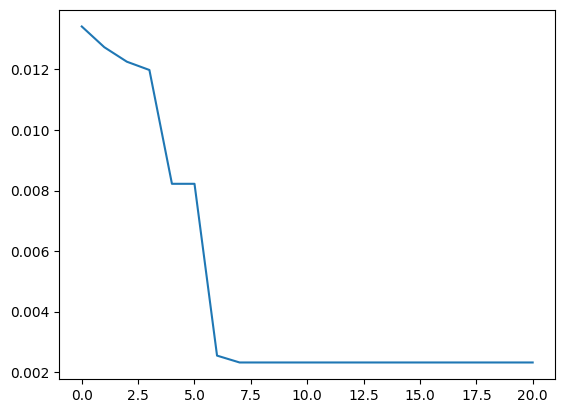

In [81]:
optimiser = HHO_ELM(100)
optimiser.optimise(20)
ec = optimiser.best_error_graph
plt.plot(ec)
preds_train = optimiser.forward_function(optimiser.weight[-1], optimiser.bias[-1], optimiser.beta[-1],  train_x)

In [82]:
print(preds_train.shape)
# print(np.array(train_y)[:, 0])
# print(np.array(preds_train)[:, 0])
error_train = (np.array(train_y)[:, 0] - np.array(preds_train)[:, 0])
# print(error_train)
print(np.mean((error_train) ** 2))

(655, 1)
0.0023210946692744255


In [83]:
preds = optimiser.forward_function(optimiser.weight[-1], optimiser.bias[-1], optimiser.beta[-1], test_x)
print(preds.shape)
error_test = (np.array(test_y)[:, 0] - np.array(preds)[:, 0])
print(np.mean(error_test ** 2))

(116, 1)
0.001984950673513704


In [84]:
np.array(preds)[:, 0]

array([0.19110731, 0.19895703, 0.19623106, 0.19283811, 0.19155265,
       0.19412016, 0.19346388, 0.19500184, 0.19467834, 0.19651732,
       0.20076967, 0.20465056, 0.20132599, 0.19260562, 0.19685289,
       0.20467766, 0.20268923, 0.19817028, 0.19496223, 0.19614056,
       0.19749082, 0.2031661 , 0.20599845, 0.20304276, 0.20526438,
       0.21210255, 0.22302841, 0.22897554, 0.22751067, 0.24739899,
       0.24373103, 0.25531163, 0.28523237, 0.2809151 , 0.29587324,
       0.28550309, 0.30546701, 0.35911301, 0.34111519, 0.30013639,
       0.29273738, 0.30770591, 0.34317878, 0.33380322, 0.34079593,
       0.34030661, 0.32557684, 0.34309433, 0.34192598, 0.36712133,
       0.38121131, 0.36343055, 0.33896065, 0.3184345 , 0.34769353,
       0.35481965, 0.34513889, 0.32328173, 0.29716685, 0.32149612,
       0.33118086, 0.32544859, 0.33378606, 0.33456262, 0.34944269,
       0.34892073, 0.3645374 , 0.36675476, 0.3763995 , 0.40694764,
       0.42380714, 0.44233672, 0.43039461, 0.43858082, 0.48777

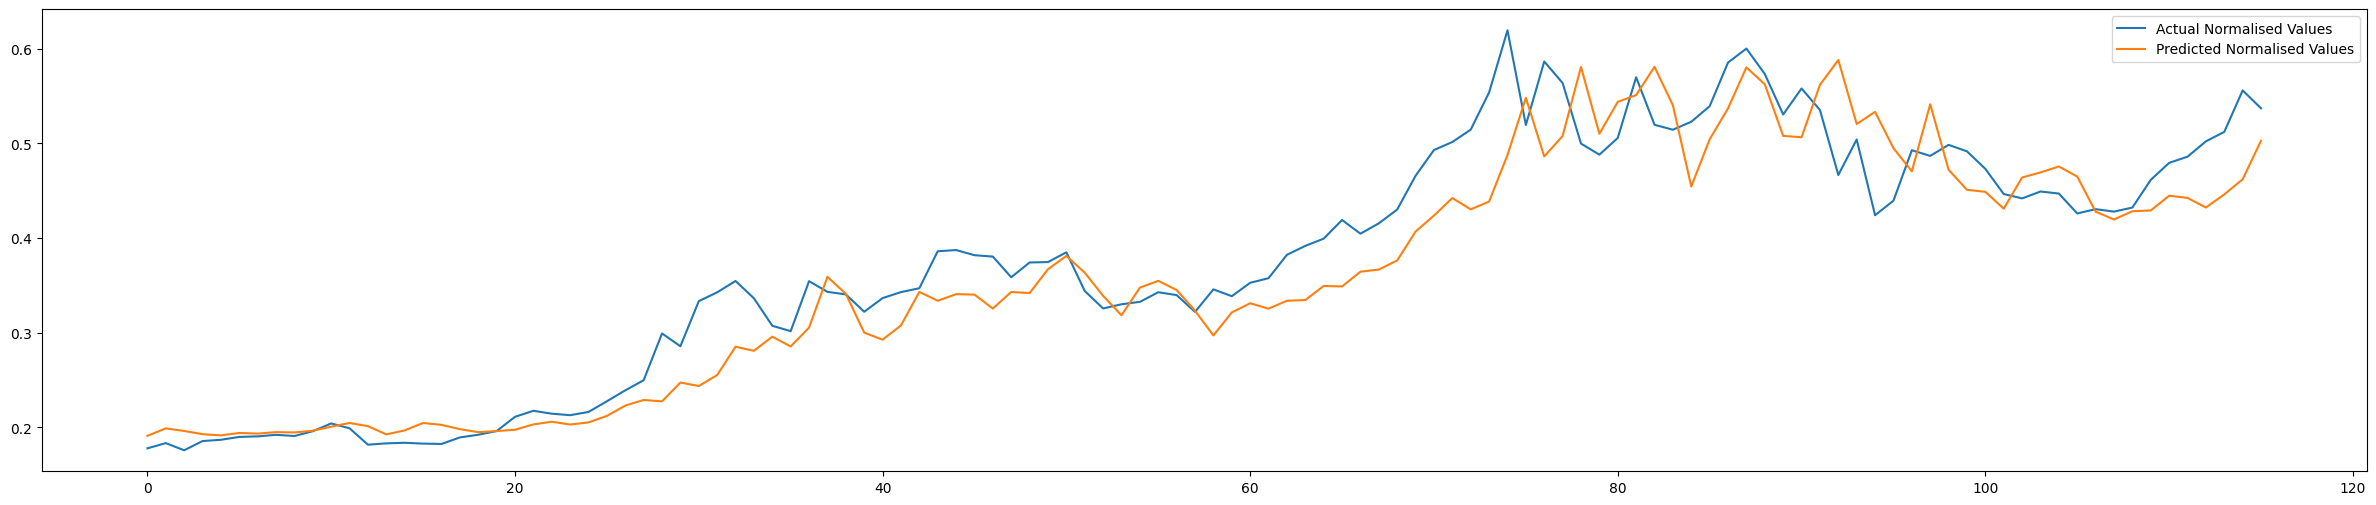

In [85]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(np.array(preds)[:, 0])
plt.legend(["Actual Normalised Values", "Predicted Normalised Values"])
plt.show()

In [86]:
denormalized_preds = denormalize(preds)
# print(denormalized_preds)
preds1 = pd.DataFrame(denormalized_preds)
preds1['DATE'] = data1.index[-1*len(preds1):]
preds1 = preds1.set_index('DATE')
print(preds1)

                       0
DATE                    
2019-04-14   5301.067603
2019-04-15   5440.323386
2019-04-16   5391.964223
2019-04-17   5331.772398
2019-04-18   5308.968126
...                  ...
2019-08-03   9760.609946
2019-08-04   9580.309262
2019-08-05   9826.601888
2019-08-06  10109.369184
2019-08-07  10832.156838

[116 rows x 1 columns]


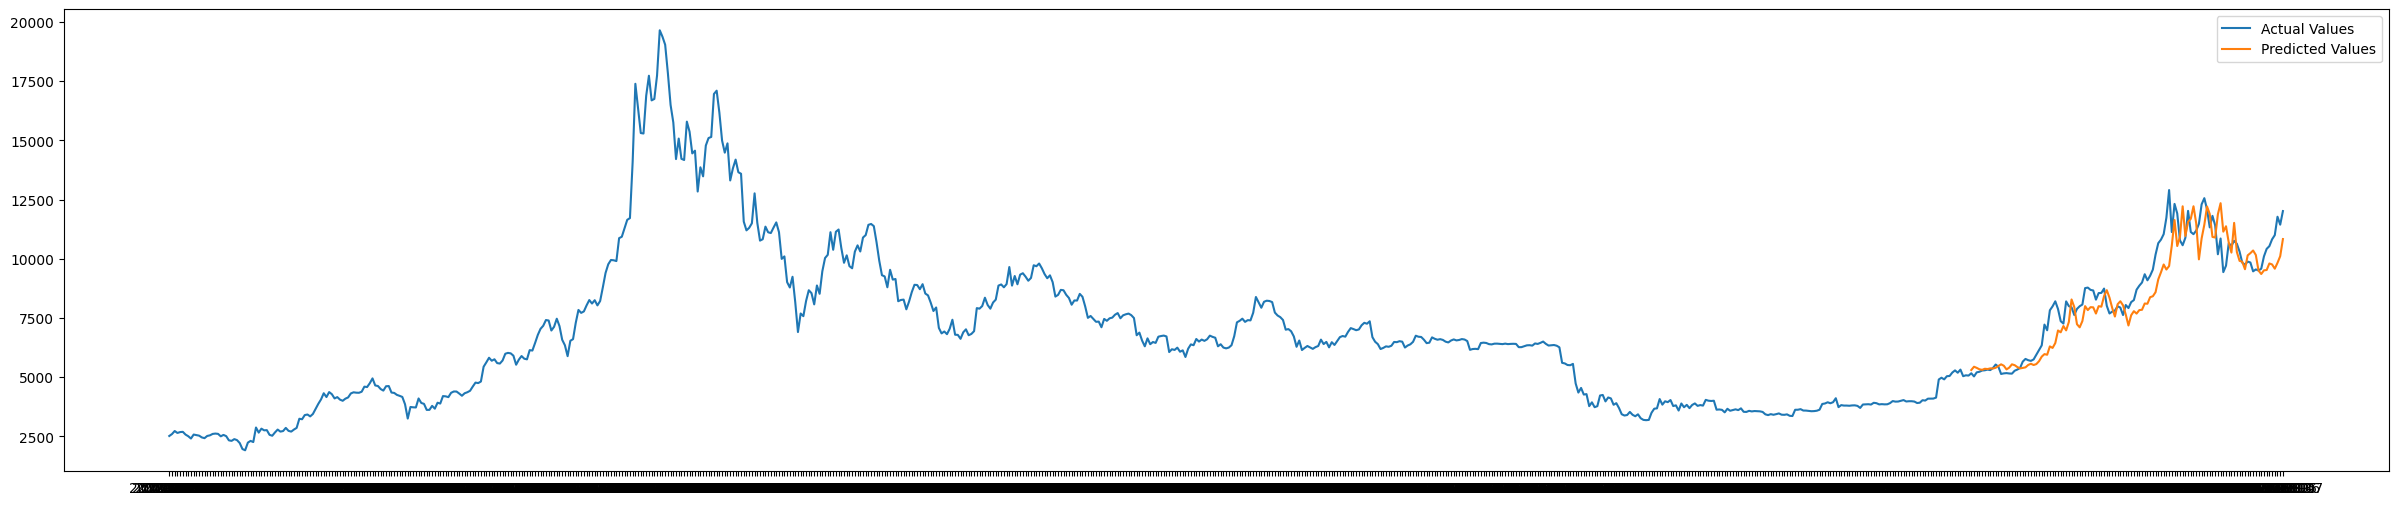

In [87]:
plt.figure(figsize=(30, 6))
plt.plot(data1)
plt.plot(preds1)
plt.legend(["Actual Values", "Predicted Values"])
plt.show()

In [88]:
mse = np.mean((np.array(preds1[0]) - np.array(data1.iloc[-1*(len(preds1)):, 0]))**2)
print("mse  "+ str(mse))
print("rmse "+ str(np.sqrt(mse)))

mse  816705.1157995603
rmse 903.7173871291624


In [89]:
(np.array(test_y) - np.array(preds))[:, 0]

array([-1.32381374e-02, -1.55608685e-02, -2.04041448e-02, -7.26441527e-03,
       -4.62046578e-03, -4.17279560e-03, -2.96014937e-03, -2.83353569e-03,
       -3.76424616e-03, -5.32264112e-04,  3.39735473e-03, -5.60466545e-03,
       -1.95904612e-02, -9.47777808e-03, -1.30999155e-02, -2.18040476e-02,
       -2.01961013e-02, -8.77532729e-03, -2.72289960e-03, -1.96561569e-05,
        1.37026106e-02,  1.43750500e-02,  8.49031207e-03,  9.86992469e-03,
        1.10614506e-02,  1.54948408e-02,  1.61065956e-02,  2.08724094e-02,
        7.17622263e-02,  3.83346216e-02,  8.96440211e-02,  8.74201157e-02,
        6.94721584e-02,  5.55055710e-02,  1.15021426e-02,  1.61626673e-02,
        4.90503783e-02, -1.58953616e-02, -5.94243343e-04,  2.20522221e-02,
        4.38535230e-02,  3.52490535e-02,  3.86463733e-03,  5.22825325e-02,
        4.65987133e-02,  4.16343221e-02,  5.48985014e-02,  1.55701265e-02,
        3.23307256e-02,  7.57674661e-03,  3.81132296e-03, -1.93408754e-02,
       -1.32895602e-02,  

In [90]:
err_test = (np.array(test_y) - np.array(preds))[:, 0]
mse_test = np.mean(err_test ** 2)
rmse_test = np.sqrt(mse_test)
mae_test = np.mean(np.abs(err_test))
mape_test = np.mean(np.abs(err_test) / np.array(test_y)[:, 0])
EBPN = pd.DataFrame([[mse_test, rmse_test, mae_test, mape_test]], columns = ["mse", "rmse", "mae", "mape"], index = ['BPN'])
EBPN

,mse,rmse,mae,mape
BPN,0.001985,0.044553,0.033976,0.084778
